### [Bibliotecas]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import plotly.express as px

from datasetCleaner import *
from YUVHandler import *
from pixelFeatures import *
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### [Leitura de YUV]

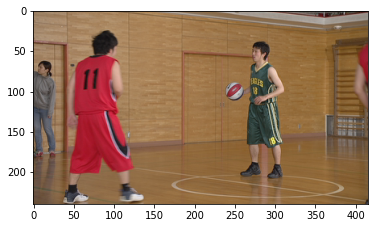

In [3]:
video_file = '/home/lindino/Documentos/(YUV) Videos/BasketballPass_416x240_50.yuv'
width = 416
height = 240

# Aquisição das matrizes Y, U e V
yuv_handle = YUVHandler(video_file, width, height)
Y, U, V = yuv_handle.get_frame_arrays()
yuv_handle.plot_frame(Y[0], U[0], V[0])

# Converter para 16 bits
Y = np.uint16(Y)
Y = Y*4
imageInput = np.pad(Y[0], (0,128), mode='edge')

In [50]:
qps = ['22', '27', '32', '37']
dfAll = pd.DataFrame()

for qp in qps:
    df_features = pd.read_csv('../../VTM-9.0/features/dataset_BasketballPass_' + qp + '_features.csv', usecols = ['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType', 'cost'])
    df_target = pd.read_csv('../../VTM-9.0/target/dataset_BasketballPass_' + qp + '_target.csv')

    splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

    for i in range(0, len(splits)):
        df_features['splitType'] = df_features['splitType'].replace(i+1, splits[i])
        df_target['splitType'] = df_target['splitType'].replace(i+1, splits[i])

    df = pd.merge(df_features, df_target, on=['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType'])
    df.drop_duplicates(inplace = True)
    df = df.groupby(by=['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType']).min()
    df.reset_index(inplace = True)
    df['target'] = df['cost'] > df['RDCost']
    df['target'] = df['target'].apply(lambda x : 1 if x else 0)
    df = df.query('bottomRight_x > 0 & bottomRight_y > 0')
    dfAll = pd.concat([dfAll, df])

dfAll.reset_index(inplace = True, drop = True)
dfAll.to_csv('../datasets/all/VTM_second.csv', index = False)

### [S0]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df = pixel_features.extractFeatures(128, 128, split)
    df.to_csv('../datasets/all/s0_' + split + '_PIXEL.csv', index = False)

In [79]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s0_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s0.csv', index = False)

In [5]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)

pixel_features.concatenateDataFrames('VTM', 's0')

#### [Modelos]

##### [QT_SPLIT]

In [6]:
df = pd.read_csv('../datasets/QT_SPLIT/s0.csv')
df.drop(columns = ['videoname', 'splitType'], inplace = True)
df['target'].value_counts()

0    7
Name: target, dtype: int64

##### [BI_HORZ || TRI_HORZ]

In [7]:
df1 = pd.read_csv('../datasets/BI_HORZ/s0.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s0.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

0    8
Name: target, dtype: int64

##### [BI_VERT || TRI_VERT]

In [8]:
df1 = pd.read_csv('../datasets/BI_VERT/s0.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s0.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

0    8
Name: target, dtype: int64

### [S1]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df1 = pixel_features.extractFeatures(128, 64, split)
    df2 = pixel_features.extractFeatures(64, 128, split)
    df = pd.concat([df1, df2])
    df.to_csv('../datasets/all/s1_' + split + '_PIXEL.csv', index = False)

In [ ]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s1_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s1.csv', index = False)

#### [Modelos]

##### [QT_SPLIT]

In [ ]:
df = pd.read_csv('../datasets/QT_SPLIT/s1.csv')
df['target'].value_counts()

##### [BI_HORZ || TRI_HORZ]

In [ ]:
df1 = pd.read_csv('../datasets/BI_HORZ/s1.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s1.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

##### [BI_VERT || TRI_VERT]

In [ ]:
df1 = pd.read_csv('../datasets/BI_VERT/s1.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s1.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

### [S2]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df1 = pixel_features.extractFeatures(64, 64, split)
    df2 = pixel_features.extractFeatures(128, 32, split)
    df3 = pixel_features.extractFeatures(32, 128, split)
    df = pd.concat([df1, df2, df3])
    df.to_csv('../datasets/all/s2_' + split + '_PIXEL.csv', index = False)

In [ ]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s2_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s2.csv', index = False)

#### [Modelo]

##### [QT_SPLIT]

In [ ]:
df = pd.read_csv('../datasets/QT_SPLIT/s2.csv')
df['target'].value_counts()

##### [BI_HORZ || TRI_HORZ]

In [21]:
df1 = pd.read_csv('../datasets/BI_HORZ/s2.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s2.csv')
df = pd.concat([df1, df2])
df['target'].value_counts().shape[0] > 1

False

In [22]:
df1 = pd.read_csv('../datasets/BI_VERT/s2.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s2.csv')
df = pd.concat([df1, df2])
df['target'].value_counts().shape[0] > 1

True

##### [BI_VERT || TRI_VERT]

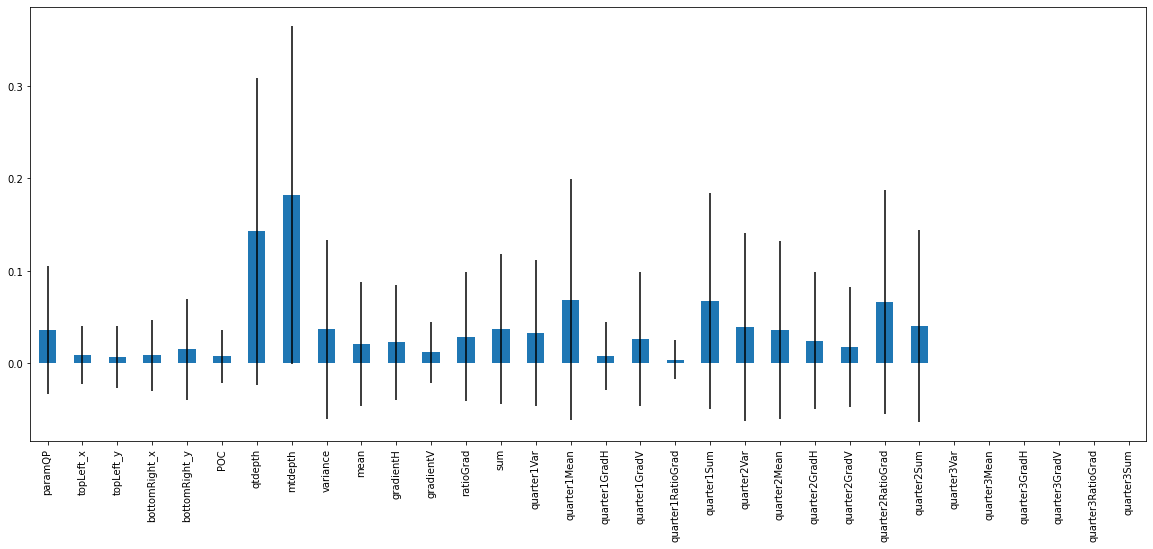

In [15]:
cleaner = datasetCleaner(path1 = 'BI_VERT', path2 = 'TRI_VERT', div = 's2')
X, y = cleaner.duplicatedFeatures()
xTrain, xTest, yTrain, yTest = train_test_split(X, y, stratify = y, random_state = 0)
cleaner.featuresImportance(xTrain, yTrain)

In [ ]:
cleaner = datasetCleaner()
X, y = cleaner.duplicatedFeatures(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

forest = RF(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
forest_importances = pd.Series(importances, index = X.columns)
forest_importances.plot.bar(yerr = std, figsize = (30,7));

In [16]:
forest = RandomForestClassifier(random_state = 0)
scores = cross_val_score(forest, X, y, cv = 10, n_jobs = 2)
scores.mean()

0.9261029411764706

In [ ]:
X, y = cleaner.duplicatedFeatures(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)
forest = RF(random_state = 0)
forest.fit(X_train, y_train)
preds = forest.predict(X_test)
print('F1-Score: {0:.2f}'.format(100*f1_score(y_test, preds)))
sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), annot = True, xticklabels=['No Split', 'Split'], yticklabels=['No Split','Split']);

In [ ]:
X, y = cleaner.duplicatedFeatures(df)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)
forest = RF(random_state = 0)
forest.fit(X_train, y_train)
preds = forest.predict(X_test)
print('F1-Score: {0:.2f}'.format(100*f1_score(y_test, preds)))
sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), annot = True, xticklabels=['No Split', 'Split'], yticklabels=['No Split','Split']);

### [S3]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df1 = pixel_features.extractFeatures(64, 32, split)
    df2 = pixel_features.extractFeatures(32, 64, split)
    df3 = pixel_features.extractFeatures(128, 16, split)
    df4 = pixel_features.extractFeatures(16, 128, split)
    df = pd.concat([df1, df2, df3, df4])
    df.to_csv('../datasets/all/s3_' + split + '_PIXEL.csv', index = False)

In [ ]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s3_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s3.csv', index = False)

#### [Modelo]

##### [QT_SPLIT]

In [ ]:
df = pd.read_csv('../datasets/QT_SPLIT/s3.csv')
df['target'].value_counts()

##### [BI_HORZ || TRI_HORZ]

In [ ]:
df1 = pd.read_csv('../datasets/BI_HORZ/s3.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s3.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

##### [BI_VERT || TRI_VERT]

In [ ]:
df1 = pd.read_csv('../datasets/BI_VERT/s3.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s3.csv')
df = pd.concat([df1, df2])
df.reset_index(inplace = True, drop = True)
df.drop(columns = ['videoname', 'splitType', 'cost', 'RDCost'], inplace = True)
df['target'].value_counts()

In [ ]:
cleaner = datasetCleaner()
X, y = cleaner.duplicatedFeatures(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

forest = RF(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
forest_importances = pd.Series(importances, index = X.columns)
forest_importances.plot.bar(yerr = std, figsize = (30,7));

In [ ]:
X, y = cleaner.duplicatedFeatures(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)
forest = RF(random_state = 0)
forest.fit(X_train, y_train)
preds = forest.predict(X_test)
print('F1-Score: {0:.2f}'.format(100*f1_score(y_test, preds)))
sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), annot = True, xticklabels=['No Split', 'Split'], yticklabels=['No Split','Split']);

In [ ]:
forest = RF(random_state = 0)
scores = cross_val_score(forest, X, y, cv = 5)
scores.mean()

### [S4]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df1 = pixel_features.extractFeatures(32, 32, split)
    df2 = pixel_features.extractFeatures(64, 16, split)
    df3 = pixel_features.extractFeatures(16, 64, split)
    df4 = pixel_features.extractFeatures(128, 8, split)
    df5 = pixel_features.extractFeatures(8, 128, split)
    df = pd.concat([df1, df2, df3, df4, df5])
    df.to_csv('../datasets/all/s4_' + split + '_PIXEL.csv', index = False)

In [ ]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s4_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s4.csv', index = False)

#### [Modelo]

##### [QT_SPLIT]

In [ ]:
df = pd.read_csv('../datasets/QT_SPLIT/s4.csv')
df['target'].value_counts()

##### [BI_HORZ || TRI_HORZ]

In [ ]:
df1 = pd.read_csv('../datasets/BI_HORZ/s4.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s4.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

##### [BI_VERT || TRI_VERT]

In [ ]:
df1 = pd.read_csv('../datasets/BI_VERT/s4.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s4.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

### [S5]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df1 = pixel_features.extractFeatures(32, 16, split)
    df2 = pixel_features.extractFeatures(16, 32, split)
    df3 = pixel_features.extractFeatures(64, 8, split)
    df4 = pixel_features.extractFeatures(8, 64, split)
    df = pd.concat([df1, df2, df3, df4])
    df.to_csv('../datasets/all/s5_' + split + '_PIXEL.csv', index = False)

In [ ]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s5_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s5.csv', index = False)

#### [Modelo]

##### [QT_SPLIT]

In [ ]:
df = pd.read_csv('../datasets/QT_SPLIT/s5.csv')
df['target'].value_counts()

##### [BI_HORZ || TRI_HORZ]

In [ ]:
df1 = pd.read_csv('../datasets/BI_HORZ/s5.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s5.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

##### [BI_VERT || TRI_VERT]

In [ ]:
df1 = pd.read_csv('../datasets/BI_VERT/s5.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s5.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

### [S6]

#### [Dataset]

In [ ]:
pixel_features = pixelFeatures('BasketballPass', Y, width, height, 4)
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    df1 = pixel_features.extractFeatures(16, 16, split)
    df2 = pixel_features.extractFeatures(32, 8, split)
    df3 = pixel_features.extractFeatures(8, 32, split)
    df = pd.concat([df1, df2, df3])
    df.to_csv('../datasets/all/s6_' + split + '_PIXEL.csv', index = False)

In [ ]:
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    dfVTM = pd.read_csv('../datasets/all/VTM.csv')
    dfPixel = pd.read_csv('../datasets/all/s6_' + split + '_PIXEL.csv')
    dfVTM = dfVTM[dfVTM['splitType'] == split]
    df = pd.merge(dfVTM, dfPixel, on = ['topLeft_x', 'topLeft_y','bottomRight_x','bottomRight_y','POC', 'CU_width', 'CU_height', 'videoname'])
    df.to_csv('../datasets/' + split + '/s6.csv', index = False)

#### [Modelo]

##### [QT_SPLIT]

In [ ]:
df = pd.read_csv('../datasets/QT_SPLIT/s6.csv')
df['target'].value_counts()

##### [BI_HORZ || TRI_HORZ]

In [ ]:
df1 = pd.read_csv('../datasets/BI_HORZ/s6.csv')
df2 = pd.read_csv('../datasets/TRI_HORZ/s6.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

##### [BI_VERT || TRI_VERT]

In [ ]:
df1 = pd.read_csv('../datasets/BI_VERT/s6.csv')
df2 = pd.read_csv('../datasets/TRI_VERT/s6.csv')
df = pd.concat([df1, df2])
df['target'].value_counts()

### [Dataset - ExtractionClass]

In [ ]:
class Extract_Features:
    def __init__(self, height, width, frame):
        self.height = height
        self.width = width
        self.Y = frame
        self.block_size_height = 0
        self.block_size_width = 0
        self.frame_padding = 0
        
    def setBlock(self, block_size):
        
        self.block_size_height = int(block_size.split('x')[0])
        self.block_size_width = int(block_size.split('x')[1])
        self.frame_padding = np.pad(self.Y, ( (0,(height % self.block_size_height)), 
                                             (0,(width % self.block_size_width)) ), 'edge')            
    
    def setDataFrame(self, array, columns):
        
        df = pd.DataFrame(columns = columns)
        for i in range(len(columns)):
            df[columns[i]] = array[:,i]
        
        return df
    
    def getVariance(self, block_size):
        self.setBlock(block_size)
        varPix = np.array([[None]*5])

        for h in range(0, self.height, self.block_size_height):
            for w in range(0, self.width, self.block_size_width):
                line = np.append([w, h, w+(self.block_size_width-1), h+(self.block_size_height-1)], 
                                np.var(self.frame_padding[h:h+(self.block_size_height-1), 
                                                             w:w+(self.block_size_width-1)]))
                varPix = np.vstack((varPix, line))
        
        return self.setDataFrame(varPix[1:,], ['topLeft_x', 'topLeft_y', 'bottomRight_x', 'bottomRight_y', 'VarPix'])
    
    def getGradients(self, block_size):
        self.setBlock(block_size)
              
        grad = np.array([[None]*7])
        
        for h in range(0, self.height, self.block_size_height):
            for w in range(0, self.width, self.block_size_width):
                Gx, Gy = np.gradient(self.frame_padding[h:h+(self.block_size_height-1), 
                                                             w:w+(self.block_size_width-1)])
                line = [w, h, w+(self.block_size_width-1), h+(self.block_size_height-1), Gx.sum(), Gy.sum(), (Gx.sum()/Gy.sum())]
                grad = np.vstack((grad, line))
        return self.setDataFrame(grad[1:,], ['topLeft_x', 'topLeft_y', 'bottomRight_x', 'bottomRight_y', 'Grad_x', 'Grad_y', 'RatioGrad'])
    
    
    def getQuarterPos(self, h, w, df_quarter, df_block):
        quarter = df_quarter[ df_quarter['topLeft_x'] >= w ]
        quarter = quarter[ quarter['topLeft_y'] >= h ]
        quarter = quarter[ quarter['bottomRight_x'] <= w + (self.block_size_width - 1) ]
        quarter = quarter[ quarter['bottomRight_y'] <= h + (self.block_size_height - 1)]
        
        quarter.reset_index(inplace = True, drop = True)

        feature = df_block[ df_block['topLeft_x'] == w ]
        feature = feature[ feature['topLeft_y'] == h ]
        feature = feature[ feature['bottomRight_x'] == w + (self.block_size_width  - 1) ]
        feature = feature[ feature['bottomRight_y'] == h + (self.block_size_height - 1) ]
        
        feature.reset_index(inplace = True, drop = True)
        
        return quarter, feature
                
    def getQuarterVariance(self, block_size, quarter_block_size, varPix, grads, mean):
        v = pd.DataFrame()
        g = pd.DataFrame()
        m = pd.DataFrame()
        quarterVar = dataset.getVariance(quarter_block_size)
        quarterGrad = dataset.getGradients(quarter_block_size)
        quarterMean = dataset.getMean(quarter_block_size)
        
        self.setBlock(block_size)
        pos = ['topLeft', 'topRight', 'bottomLeft', 'bottomRight']
        
        for h in range(0, self.height, self.block_size_height):
            for w in range(0, self.width, self.block_size_width):
                
                quarterVar_aux, varPix_aux = self.getQuarterPos(h, w, quarterVar, varPix)
                quarterGrad_aux, grad_aux = self.getQuarterPos(h, w, quarterGrad, grads)
                quarterMean_aux, mean_aux = self.getQuarterPos(h, w, quarterMean, mean)
                
                for i in range(1,len(pos)+1):
                    if quarterVar_aux.shape[0] >= i:
                        varPix_aux['QuarterVarPix_' + pos[i-1]] = quarterVar_aux['VarPix'][i-1]
                        grad_aux['QuarterGrad_x_' + pos[i-1]] = quarterGrad_aux['Grad_x'][i-1]
                        grad_aux['QuarterGrad_y_' + pos[i-1]] = quarterGrad_aux['Grad_y'][i-1]
                        grad_aux['QuarterRatioGrad_' + pos[i-1]] = quarterGrad_aux['RatioGrad'][i-1]
                        mean_aux['QuarterMean_' + pos[i-1]] = quarterMean_aux['Mean'][i-1]
                 
                v = pd.concat([v, varPix_aux], sort=False)
                g = pd.concat([g, grad_aux], sort=False)
                m = pd.concat([m, mean_aux], sort=False)
                d = pd.merge(v,g)
        return pd.merge(d,m)
    
    def getInconsistency(self, df, feature):
        max_lines = df.shape[0]
        HI = np.array([[None]*1])
        VI = np.array([[None]*1])
        
        for i in range(max_lines):
            f1 = df.loc[i,'Quarter' + feature + '_topLeft']
            f2 = df.loc[i, 'Quarter' + feature + '_topRight']
            f3 = df.loc[i, 'Quarter' + feature + '_bottomLeft']
            f4 = df.loc[i, 'Quarter' + feature + '_bottomRight']
            
            if f3 != None or f4 != None:

                h = abs(f1 - f2) + abs(f3 - f4)
                v = abs(f1 - f3) + abs(f2 - f4)

                HI = np.vstack((HI, h))
                VI = np.vstack((VI, v))
            else:
                HI = np.vstack((HI, None))
                VI = np.vstack((VI, None))
        return HI,VI
    
    def getMean(self, block_size):
        self.setBlock(block_size)
        mean = np.array([[None]*5])

        for h in range(0, self.height, self.block_size_height):
            for w in range(0, self.width, self.block_size_width):
                line = np.append([w, h, w+(self.block_size_width-1), h+(self.block_size_height-1)], 
                                np.mean(self.frame_padding[h:h+(self.block_size_height-1), 
                                                             w:w+(self.block_size_width-1)]))
                mean = np.vstack((mean, line))
        
        return self.setDataFrame(mean[1:,], ['topLeft_x', 'topLeft_y', 'bottomRight_x', 'bottomRight_y', 'Mean'])

### [Dataset Image]

In [ ]:
df_image = pd.DataFrame()

for i in range(1,16):

    dataset = Extract_Features(height, width, Y[i])
    varPix = dataset.getVariance('128x128')
    grads = dataset.getGradients('128x128')
    mean = dataset.getMean('128x128')
    v = dataset.getQuarterVariance('128x128', '64x64', varPix, grads, mean)
    
    df = pd.merge(varPix, grads)
    df = pd.merge(df, v)
    
    HI, VI = dataset.getInconsistency(df, 'VarPix')
    df = pd.concat([df, pd.DataFrame(HI[1:,], columns=['HI_VarPix'])], axis = 1)
    df = pd.concat([df, pd.DataFrame(VI[1:,], columns=['VI_VarPix'])], axis = 1)

    HI, VI = dataset.getInconsistency(df, 'RatioGrad')
    df = pd.concat([df, pd.DataFrame(HI[1:,], columns=['HI_RatioGrad'])], axis = 1)
    df = pd.concat([df, pd.DataFrame(VI[1:,], columns=['VI_RatioGrad'])], axis = 1)
    
    HI, VI = dataset.getInconsistency(df, 'Mean')
    df = pd.concat([df, pd.DataFrame(HI[1:,], columns=['HI_Mean'])], axis = 1)
    df = pd.concat([df, pd.DataFrame(VI[1:,], columns=['VI_Mean'])], axis = 1)
    
    df['DiffInconsPix'] = df['HI_VarPix'] - df['VI_VarPix']
    df['DiffInconsRatioGrad'] = df['HI_RatioGrad'] - df['VI_RatioGrad']
    df['DiffInconsMean'] = df['HI_Mean'] - df['VI_Mean']
    df['GOP'] = i
    
    df_image = pd.concat([df_image, df], sort=False)
    
df_image.dropna(inplace = True)
df_image.shape


### [Features Selection]

In [ ]:
def MI(df, plot=True):
    x = df.drop(columns= 'splitColumn', axis = 1)
    constant_filter = VarianceThreshold(threshold=0.01)
    constant_filter.fit(x)
    xFilter = constant_filter.transform(x)
    columnsFilter = x.columns[constant_filter.get_support()]

    x_T = xFilter.T
    x_T = pd.DataFrame(x_T)
    
    duplicatedFeatures = x_T.duplicated()
    featuresToKeep = [not index for index in duplicatedFeatures]

    xUnique = x_T[featuresToKeep].T
    columnsUnique = columnsFilter[featuresToKeep]

    xUnique.columns = columnsUnique
    
    X = xUnique
    Y = df['splitColumn']
    
    if plot:

        mi = mutual_info_classif(X, Y)
        mi = pd.Series(mi)
        mi.index = X.columns
        mi.sort_values(ascending = False, inplace = True)
        plt.ylabel('Mutal Information (MI)')
        plt.title('Model 128x128 QP 22')
        mi.plot.bar(figsize = (16,5), color='red', grid=True)

    return X, Y

X, Y = MI(df_all[df_all['QP'] == 22])

### [Training]

In [ ]:
def simpleTraining(X, Y, imblearn, ax, title):
    
    if imblearn:
        undersample = RandomUnderSampler(sampling_strategy='all', random_state = 0)
        X, Y = undersample.fit_resample(X, Y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size = 0.25)
    clf = RF(random_state=0)
    clf.fit(X_train, y_train)
    predicts = clf.predict(X_test)
    cm = sns.heatmap(confusion_matrix(y_test, predicts, normalize='true'), annot = True, xticklabels=['No Split', 'Split'], yticklabels=['No Split','Split'], ax = ax)
    
    if ax == None:
        plt.title('Confusion Matrix - Model 128x128 ' + title)
    else:
        ax.set_title('Confusion Matrix - Model 128x128 ' + title)

    
    return f1_score(y_test, predicts)